In [1]:
import math
from tesspy import Tessellation, poi_data
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, MultiLineString
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm, PowerNorm
import matplotlib.ticker as mticker
import visualizations as vis
from scipy.stats import gaussian_kde
power_norm = PowerNorm(.25)

ModuleNotFoundError: No module named 'visualizations'

In [2]:
#load data
#load tile level annotation data
tile_level_annotations = gpd.read_file("/hpc/group/borsuklab/ast/tile-level-annotations/tile_level_annotations.shp")
tile_level_annotations = tile_level_annotations.to_crs(epsg=4326) #reproject to gps coords

#load conus boundary data
conus_boundary = gpd.read_file("/work/csr33/data/unzip/us/generalized_conus_country_boundary/generalized_conus_country_boundary.shp")

#load irs refineries data
irs_refineries_terminals_dir = "/hpc/group/borsuklab/ast/irs-refineries-terminal"
refineries_conus, terminals_conus = vis.get_active_refineries_terminals_in_conus(irs_refineries_terminals_dir, conus_boundary)
irs_terminals_refineries = pd.concat([refineries_conus[["ShortLabel","X","Y","geometry"]], terminals_conus[["ShortLabel","X","Y","geometry"]]])
terminals_refineries_xy = np.vstack([irs_terminals_refineries.X, irs_terminals_refineries.Y])
terminals_refineries_density = gaussian_kde(terminals_refineries_xy)(terminals_refineries_xy)
norm_terminals_refineries_density = (terminals_refineries_density/max(terminals_refineries_density))

DriverError: /work/csr33/data/unzip/us/generalized_conus_country_boundary/generalized_conus_country_boundary.shp: No such file or directory

In [6]:
#obtain square tesselations at various resolutions

In [19]:
#specify area unit + unit conversion
area_unit = "100 $\mathregular{km^{2}}$"
meter_to_area_unit_conversion_factor = 100000000
#get tesselation
sqr_tess_conus_8 = vis.sqr_tess_conus(8, conus_boundary)
sqr_tess_conus_8_w_density = vis.add_density_to_tess(sqr_tess_conus_8, tile_level_annotations, meter_to_area_unit_conversion_factor)
sqr_tess_conus_9 = vis.sqr_tess_conus(9, conus_boundary)
sqr_tess_conus_9_w_density = vis.add_density_to_tess(sqr_tess_conus_9, tile_level_annotations, meter_to_area_unit_conversion_factor)
sqr_tess_conus_10 = vis.sqr_tess_conus(10, conus_boundary)
sqr_tess_conus_10_w_density = vis.add_density_to_tess(sqr_tess_conus_10, tile_level_annotations, meter_to_area_unit_conversion_factor)
sqr_tesses = [[sqr_tess_conus_8, sqr_tess_conus_8_w_density, "8"],
              [sqr_tess_conus_9, sqr_tess_conus_9_w_density, "9"],
              [sqr_tess_conus_10, sqr_tess_conus_10_w_density, "10"]]

In [4]:
#set color bar
Greens = mpl.cm.get_cmap('Greens',100)
newcolors = Greens(np.linspace(0, 1, 100)) #1 just replaces the white; 2 changes half and so on
white = np.array([1, 1, 1, 1])
newcolors[:1, :] = white
Greens_with_white = ListedColormap(newcolors)

In [ ]:
#create plots

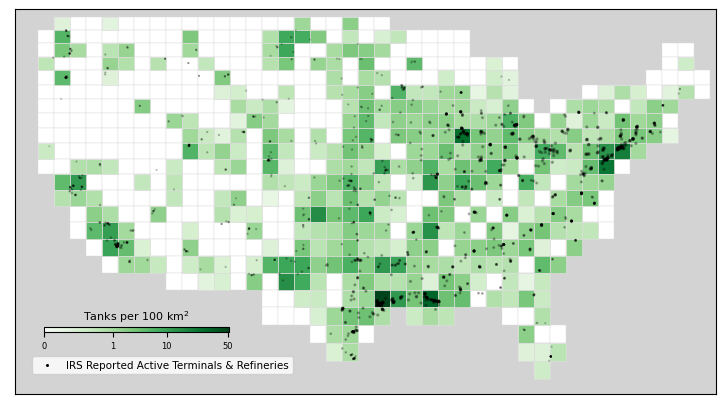

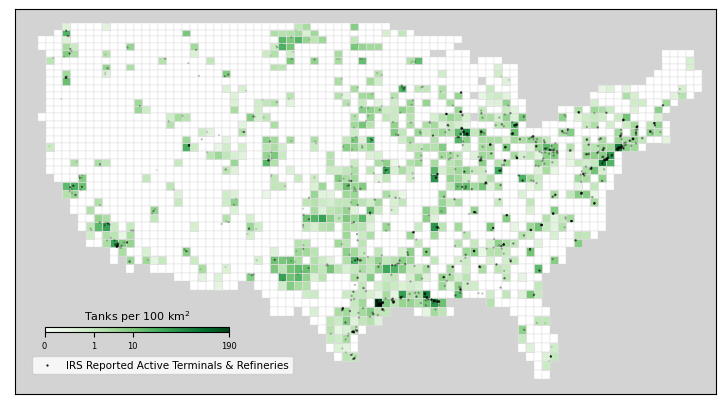

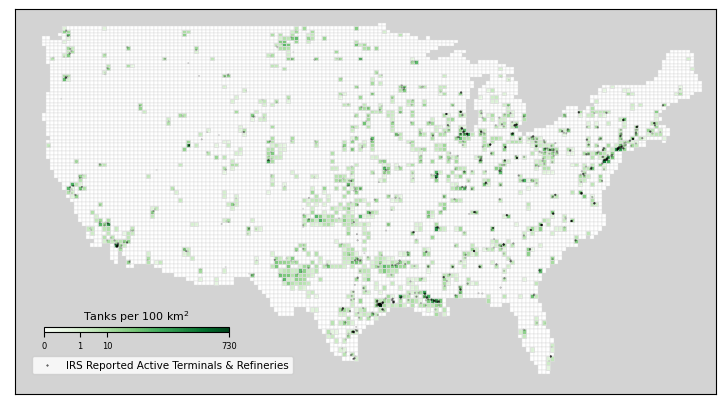

In [28]:
for i in range(len(sqr_tesses)):
    
    max_density = max(sqr_tesses[i][1]["density"])
    fig, ax = plt.subplots(1,1, figsize=(12,5))
    minx,miny,maxx,maxy = conus_boundary.bounds.values[0]
    ax.set_facecolor("lightgray")
    ax.set_xlim(minx*1.02, maxx*0.98)
    ax.set_ylim(miny*0.94, maxy*1.02)
    #ax.axis('off')
    ax.set_xticks(()) #remove y ticks
    ax.set_yticks(()) #remove y ticks
    sqr_tesses[i][0].plot(ax=ax, lw=0.3, edgecolor="gainsboro",
                       facecolor="white")
    power_norm = PowerNorm(.25,vmin=0, vmax=max_density)
    sqr_tesses[i][1].plot(ax=ax, column='density', lw=0.5, edgecolor="gainsboro",
                          cmap=Greens_with_white, norm=power_norm, vmin=0, vmax=max_density)
    # Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
    # You can change 0.01 to adjust the distance between the main image and the colorbar.
    # You can change 0.02 to adjust the width of the colorbar.
    # This practice is universal for both subplots and GeoAxes.
    dist_to_plot = 0.125
    cbar_width =0.01
    cax = fig.add_axes([ax.get_position().x0+0.025, ax.get_position().y0+dist_to_plot,
                        ax.get_position().height*.2, cbar_width])

    cb = fig.colorbar(mpl.cm.ScalarMappable(cmap = Greens_with_white, norm=power_norm), 
                      cax=cax, orientation='horizontal', pad=0.01)
    #label for distribution of our dataset
    cb.set_label(f"Tanks per {area_unit}", fontsize=8, labelpad=-30) #label colorbar
    # fixing yticks with matplotlib.ticker "FixedLocator"
    label_format = '{:,.0f}'#0 for 0 decimal places, 2 for two decimal places
    ticks_loc = [0, 1, 10, vis.round_down_to_nearest_5(max_density)]
    cb.ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    cb.ax.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize = 6)
    
    irs_terminals_refineries.plot(ax=ax, marker=".", color="black", alpha=.25,
                                  label='IRS Reported Active Terminals & Refineries',
                                  markersize=norm_terminals_refineries_density*10/((1+i)**2))
    leg = ax.legend(bbox_to_anchor=(0.025, 0.1), loc='upper left', borderaxespad=0,
                   fontsize = 7.5)
    for lh in leg.legendHandles: 
        lh.set_alpha(1) 
    fig.savefig("/hpc/home/csr33/ast-infousa-visualizations/figures/tesspy_sqr_tess_density"+sqr_tesses[i][2]+".png")

# Hexabin plot matplotlib

In [ ]:
hex_tess_conus_2 = vis.hex_tess_conus(2, conus_boundary)
hex_tess_conus_2_w_density = vis.add_density_to_tess(hex_tess_conus_2, tile_level_annotations)
hex_tess_conus_3 = vis.hex_tess_conus(3, conus_boundary)
hex_tess_conus_3_w_density = vis.add_density_to_tess(hex_tess_conus_3, tile_level_annotations)
hex_tess_conus_4 = vis.hex_tess_conus(4, conus_boundary)
hex_tess_conus_4_w_density = vis.add_density_to_tess(hex_tess_conus_4, tile_level_annotations)

hex_tesses = [[hex_tess_conus_2, hex_tess_conus_2_w_density, "2"],
              [hex_tess_conus_3, hex_tess_conus_3_w_density, "3"],
              [hex_tess_conus_4, hex_tess_conus_4_w_density, "4"]]

In [43]:
for i in range(len(hex_tesses)):
    max_density = max(hex_tesses[i][1]["density"])
    fig, ax = plt.subplots(1,1, figsize=(12,5))
    minx,miny,maxx,maxy = conus_boundary.bounds.values[0]
    ax.set_facecolor("lightgray")
    ax.set_xlim(minx*1.05, maxx*0.95)
    ax.set_ylim(miny*0.95, maxy*1.05)
    #ax.axis('off')
    ax.set_xticks(()) #remove y ticks
    ax.set_yticks(()) #remove y ticks
    # add conus in tesselation to plot
    hex_tesses[i][0].plot(ax = ax, lw=0.3, edgecolor="gainsboro",
                       facecolor = "white")
    # add conus tesselation with tile level annotation counts
    power_norm = PowerNorm(.25, vmin=0, vmax=max_density)
    hex_tesses[i][1].plot(ax = ax, column='density', lw=0.25, edgecolor="whitesmoke",
                          cmap=Greens_with_white, norm=power_norm, vmin=0, vmax=max_density)
    # Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
    # You can change dist_to_plot to adjust the distance between the main image and the colorbar.
    # You can change cbar_width to adjust the width of the colorbar.
    dist_to_plot = 0.075
    cbar_width =0.01
    cax = fig.add_axes([ax.get_position().x0+0.015, ax.get_position().y0+dist_to_plot,
                        ax.get_position().height*.21, cbar_width])

    cb = fig.colorbar(mpl.cm.ScalarMappable(cmap = Greens_with_white, norm=power_norm), cax=cax, 
                      orientation='horizontal',pad=0.01)
    cb.set_ticks([50, 1000, round_down_to_nearest_25(max_count)], fontsize=7.5)
    #label for distribution of our dataset
    cb.set_label('Number of Tanks', fontsize=7.5, labelpad=-30) #label colorbar
    label_format = '{:,.0f}'
    ticks_loc = [25, 250, 2500, round_down_to_nearest_25(max_count)]
    cb.ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    cb.ax.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize = 6)

    irs_terminals_refineries.plot(ax=ax, marker=".", color="black", label='IRS Reported Active Terminals & Refineries',
                     markersize=norm_terminals_refineries_density*10/((1+i)**2), alpha=.25)
    ax.legend(loc="best")
    leg = plt.legend(bbox_to_anchor=(0.025, 0.2), loc='upper left', borderaxespad=0,
                    fontsize = 7.5)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
    fig.savefig("/hpc/home/csr33/ast-infousa-visualizations/figures/tesspy_hexbin_density"+hex_tesses[i][2]+".png")

NameError: name 'hex_tesses' is not defined